In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as models
import torchvision.transforms.functional as TF
import wandb
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

from custom_datasets import dataset
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

wandb_api.login()
api = wandb.Api()
run_name = "3uegu1ye"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [29]:
training_data_at = wandb.Api().artifact(
    "matiasetcheverry/microstructure-reconstruction/train_df:10_images"
)
test_data_at = wandb.Api().artifact(
    "matiasetcheverry/microstructure-reconstruction/test_df:10_images"
)
training_data_at.download()
test_data_at.download()
train_df = wandb_api.convert_table_to_dataframe(training_data_at.get("fabrics"))
train_df["photos"] = train_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
test_df = wandb_api.convert_table_to_dataframe(test_data_at.get("fabrics"))
test_df["photos"] = test_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
df = test_df[test_df["id"] == "Spec-1"]
type(df["photos"].iloc[0]), df["photos"].iloc[0]


(list,
 ['/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[15.4165].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[23.7498].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[32.0831].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[40.4163].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[48.7496].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[57.0828].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[65.4161].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[7.0833].png',
  '/home/matias/microstructure-reconstruction/REV1_600/REV1_600Slices/10pics/Spec-1_Imgs/x-y[73.7494].png',
  '/home/matias/micros

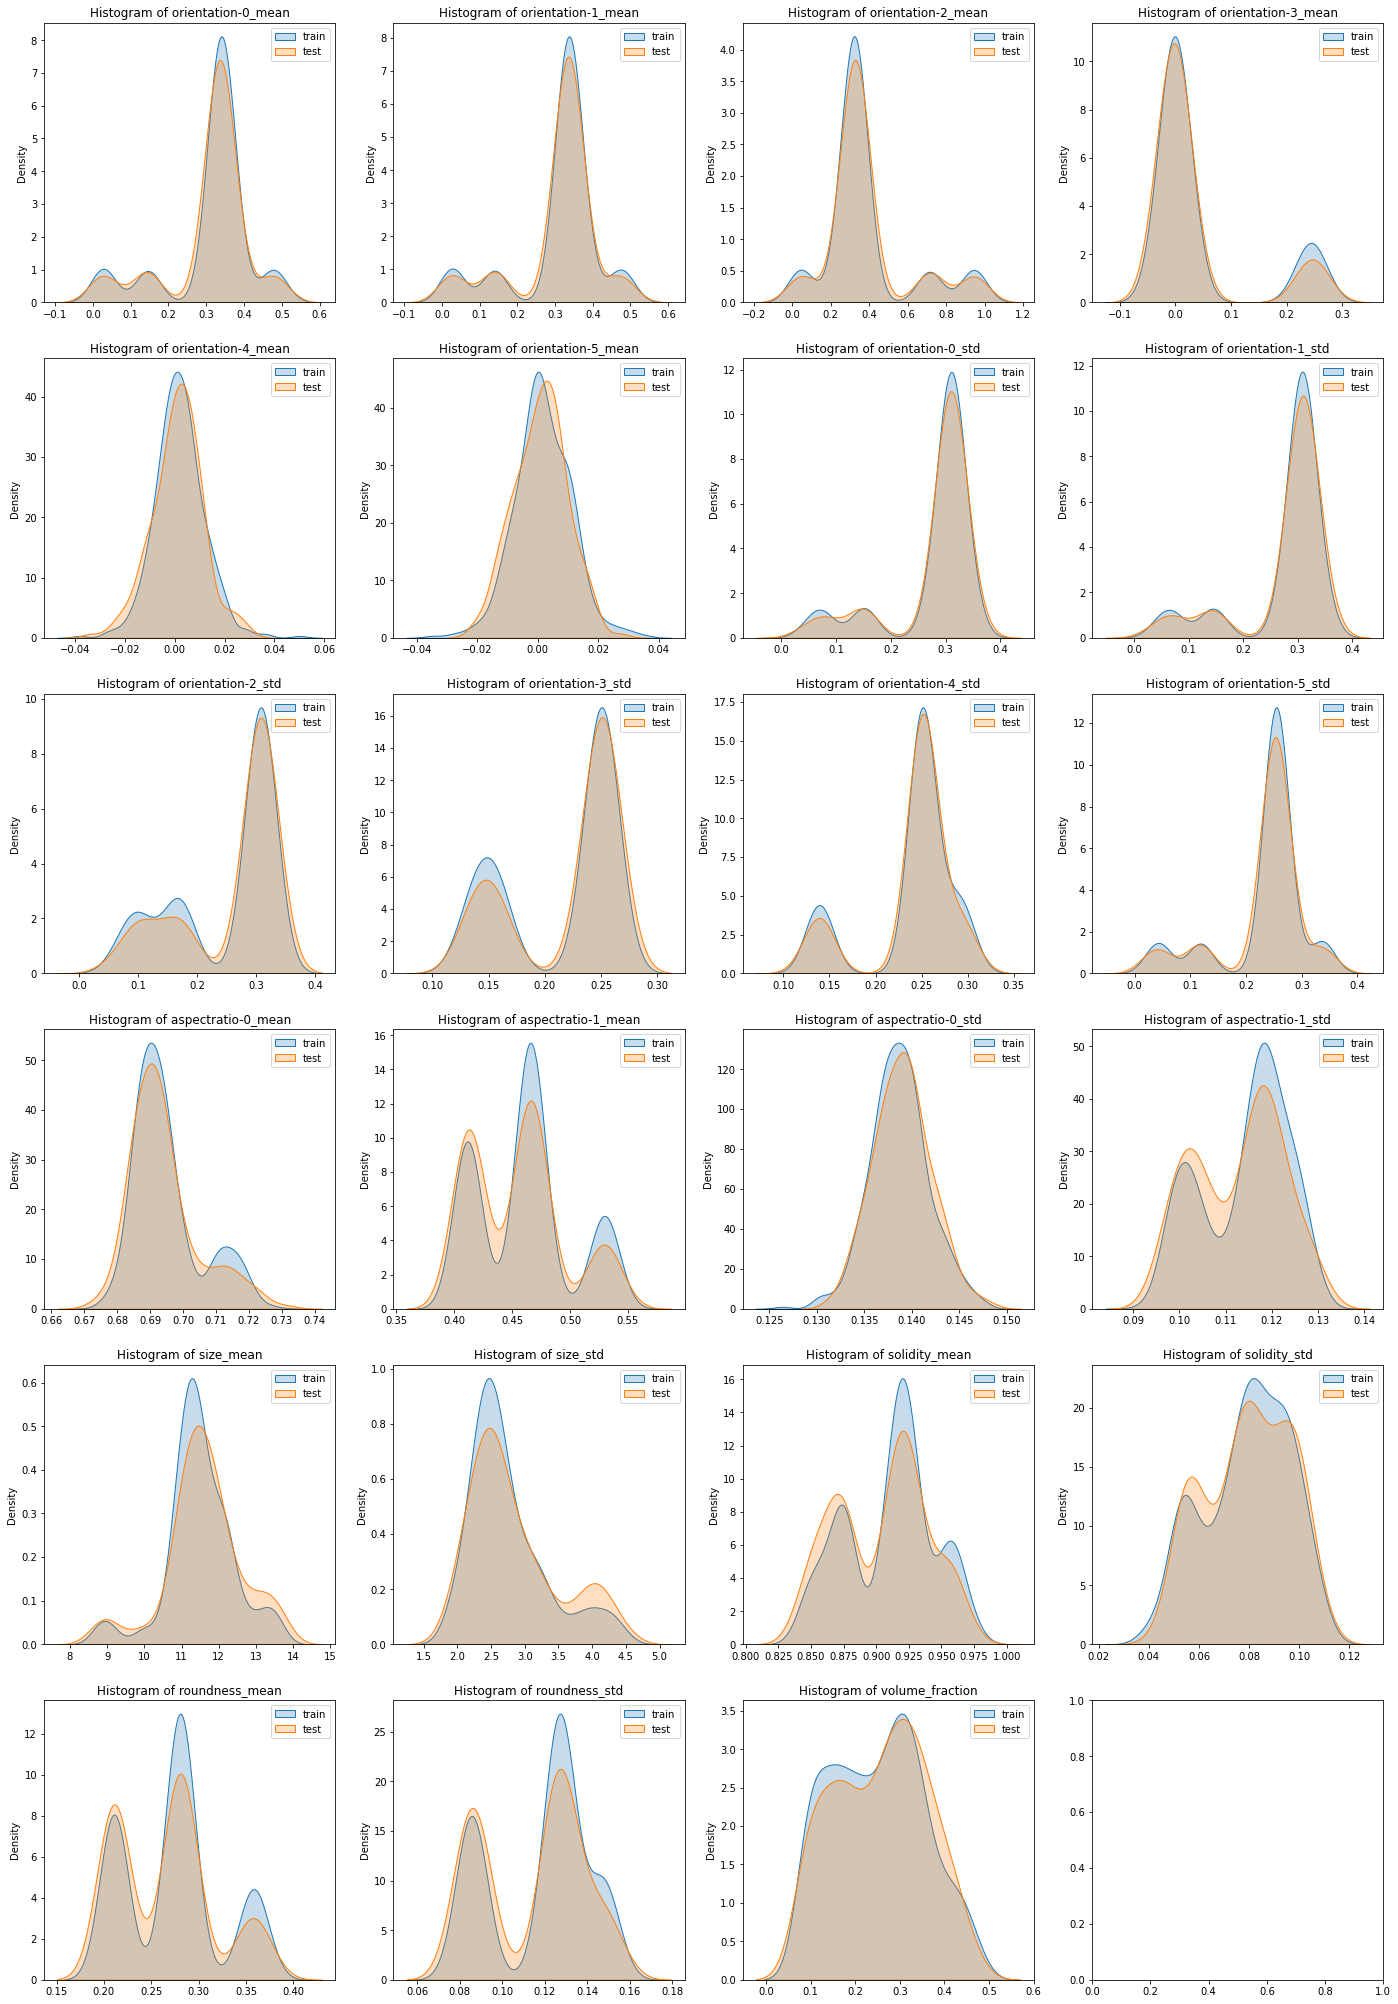

In [3]:
fig = plotting.plot_kde(
    [train_df.iloc[:, 1:-1], test_df.iloc[:, 1:-1]],
    nb_hist_per_line=4,
    labels=["train", "test"],
)


In [71]:
a = [
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_x_1-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_x_2-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_x_3-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_y_1-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_y_2-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_y_3-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_z_1-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_z_2-3_128x128.png",
    "/home/matias/microstructure-reconstruction/REV1_600/REV1_6003D_model/3_Spec-0_Imgs_original/image_slice_z_3-3_128x128.png",
]

df.iat[0, -1] = a


tensor([[ 0.3242,  0.3547,  0.3211,  0.0237,  0.0227,  0.0171,  0.3073,  0.3142,
          0.3077,  0.2529,  0.2419,  0.2561,  0.6931,  0.4142,  0.1386,  0.1049,
         13.6881,  4.4760,  0.8514,  0.0975,  0.2108,  0.0869,  0.3862]])
tensor([[ 0.3547,  0.3242,  0.3211,  0.0227, -0.0237, -0.0171,  0.3142,  0.3073,
          0.3077,  0.2419,  0.2529,  0.2561,  0.6931,  0.4142,  0.1386,  0.1049,
         13.6881,  4.4760,  0.8514,  0.0975,  0.2108,  0.0869,  0.3862]])


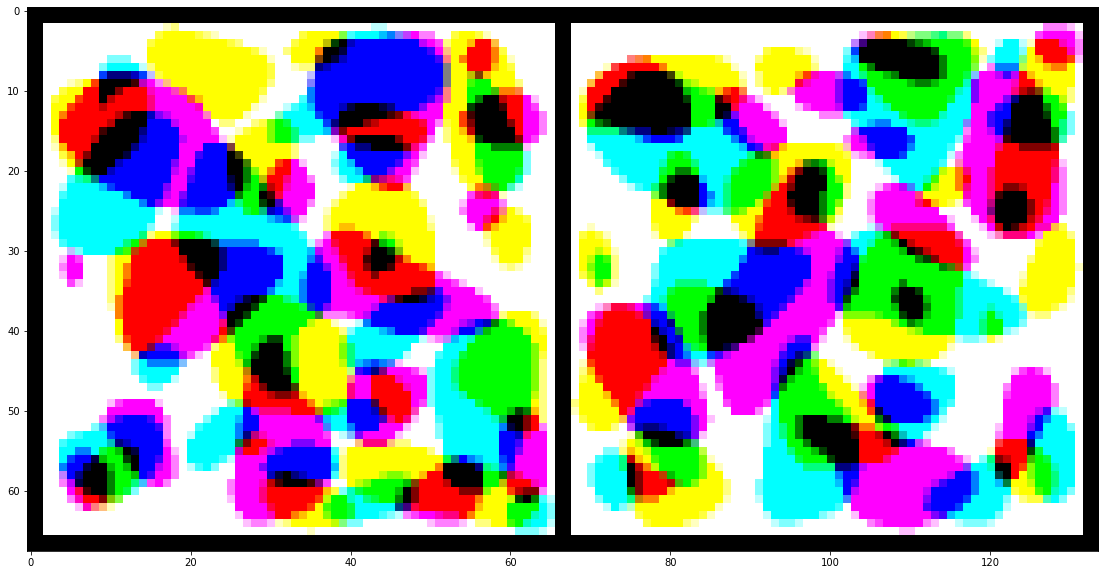

In [171]:
from custom_datasets import data_augm

reload(dataset)
reload(dataframe_reformat)
reload(data_augm)
transform = transforms.Compose(
    [
        # transforms.CenterCrop(207),
        transforms.Resize((config["input_width"], config["input_width"])),
        # transforms.GaussianBlur(kernel_size=5, sigma=1),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
ds = dataset.NChannelPhotosDataset(
    df,
    nb_input_photos_per_plane=1,
    transform=transform,
    proba_rotating=0,
)
ds_rotated = dataset.NChannelPhotosDataset(
    df,
    nb_input_photos_per_plane=1,
    transform=transform,
    proba_rotating=1,
    proba_axis={0: 0, 1: 0, 2: 1},
    proba_angle={90: 0, -90: 1},
)
images, labels = ds[0]
print(labels)
images_rotated, labels = ds_rotated[0]
print(labels)

grid = utils.make_grid(torch.cat([images, images_rotated]))
fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


In [97]:
ds = dataset.NChannelPhotosDataset(
    df,
    nb_input_photos_per_plane=10,
    transform=transform,
    proba_rotating=1,
    proba_axis={0: 0, 1: 0, 2: 1},
    proba_angle={-90: 1, 90: 0},
)
images, labels = ds[0]
print(labels)


AssertionError: 

In [44]:
reload(dataset)

transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config["input_width"], config["input_width"])),
        transforms.GaussianBlur(kernel_size=5, sigma=1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

ds = dataset.NChannelPhotosDataset(
    df=train_df,
    nb_input_photos_per_plane=1,
    transform=transform,
    proba_rotating=1,
    proba_axis={0: 1 / 3, 1: 1 / 3, 2: 1 / 3},
    proba_angle={90: 0.5, -90: 0.5},
)
augmented_targets = np.stack([label for _, label in ds])


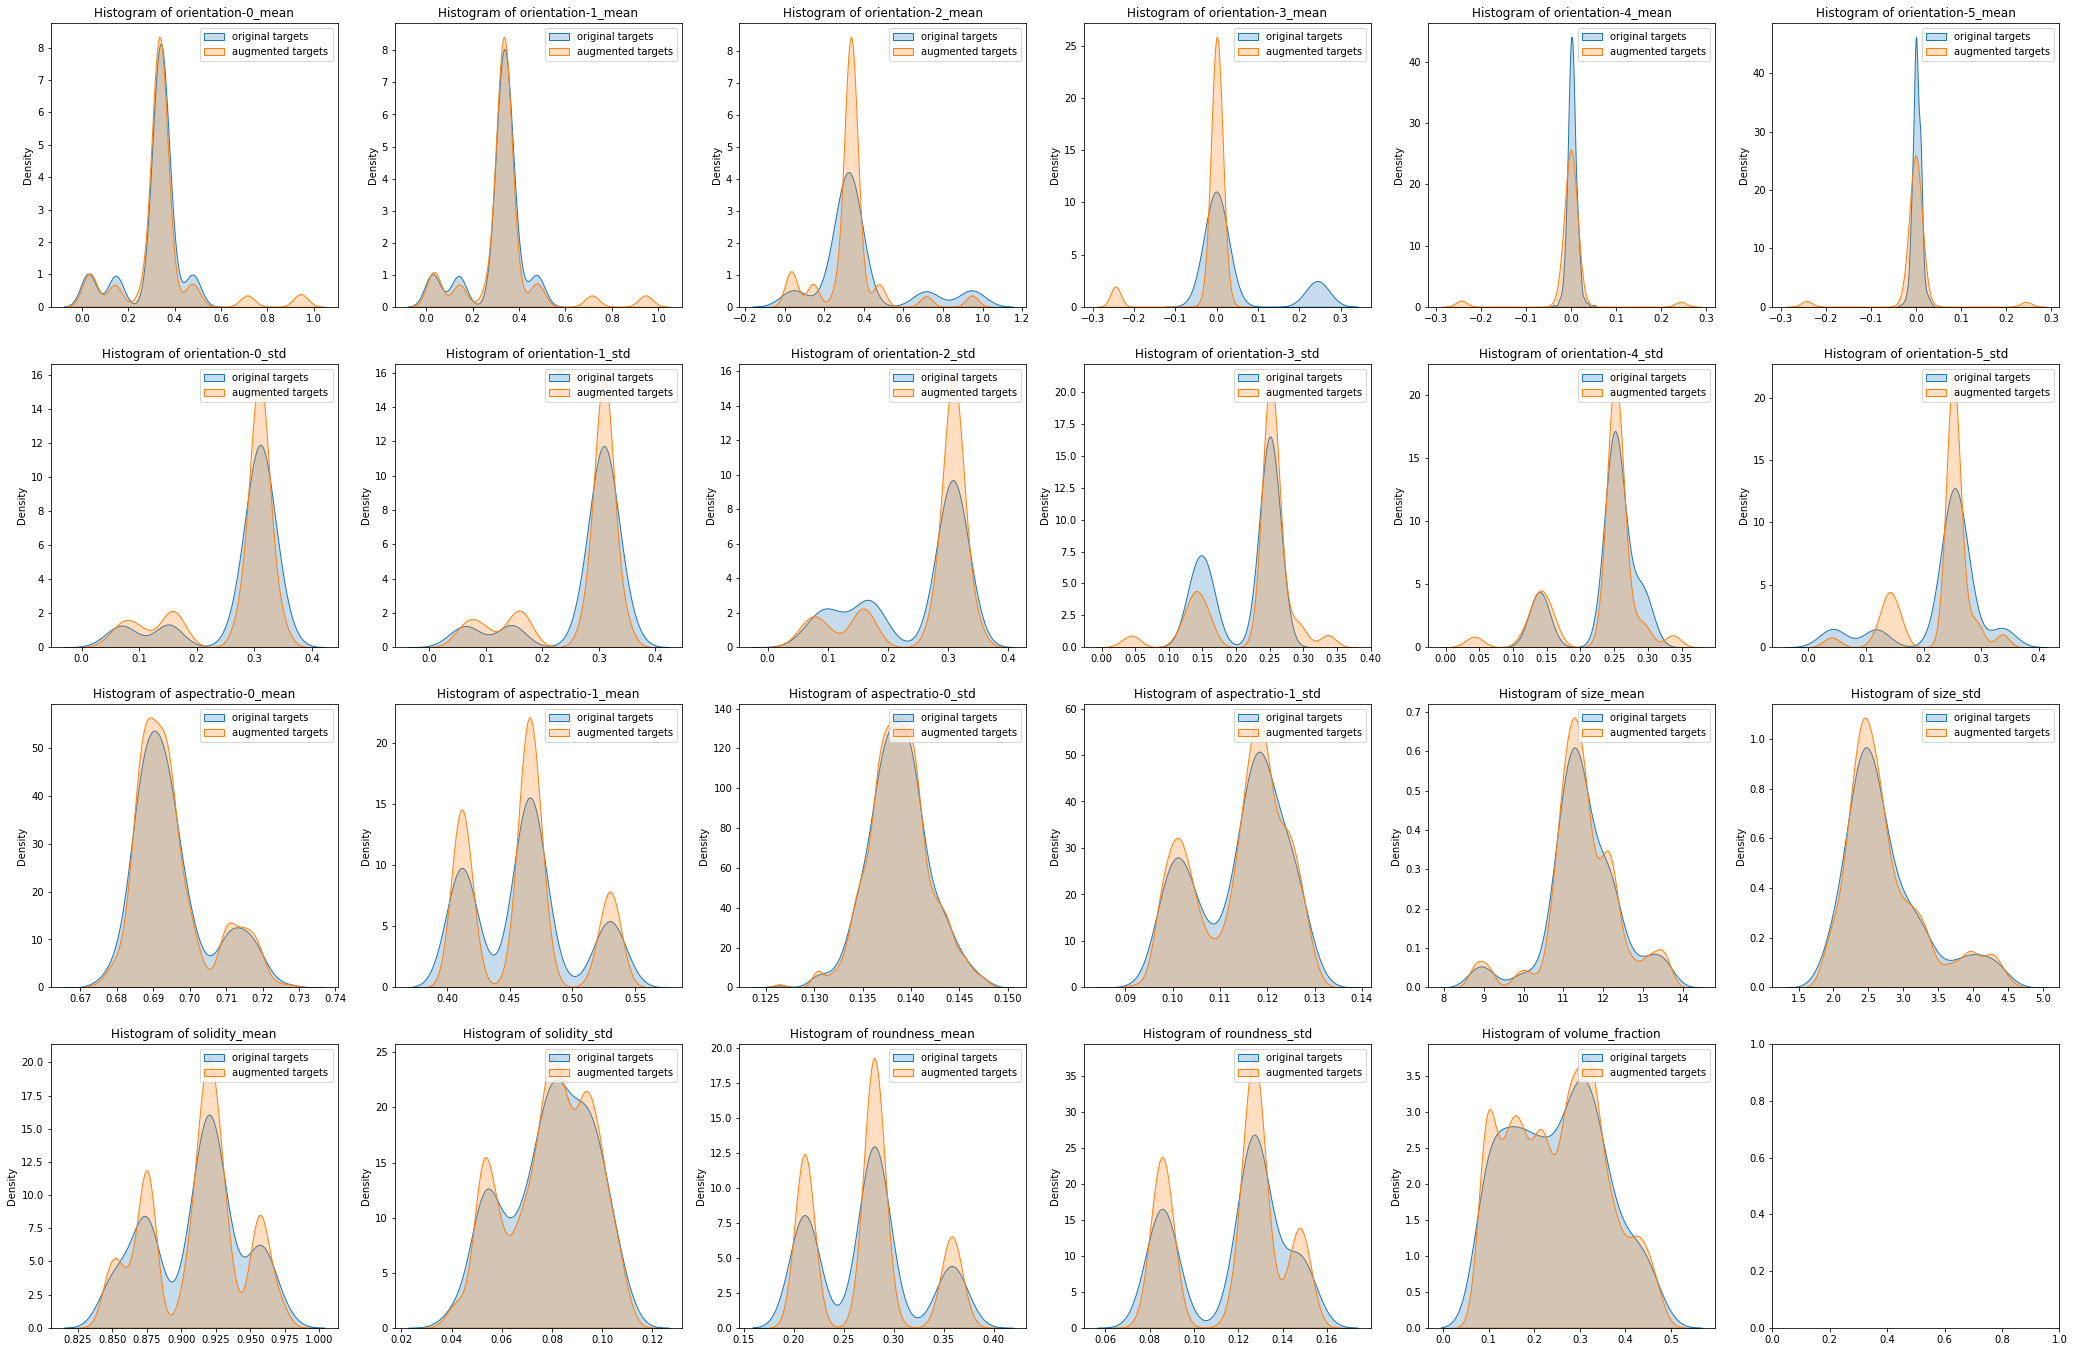

In [45]:
fig = plotting.plot_kde(
    [train_df.iloc[:, 1:-1], augmented_targets],
    nb_hist_per_line=6,
    labels=["original targets", "augmented targets"],
)
